Extracted the key parts from https://github.com/JuliaMath/RandomMatrices.jl/blob/master/src/densities/TracyWidom.jl

In [16]:
using SpecialFunctions, FastGaussQuadrature, LinearAlgebra

In [17]:
airy_kernel(x, y) = x==y ? (airyaiprime(x))^2 - x * (airyai(x))^2 :
           (airyai(x) * airyaiprime(y) - airyai(y) * airyaiprime(x)) / (x - y)
ϕ(ξ, s) =  s + 10*tan(π*(ξ+1)/4) # Transformation from [-1,1] to (s,∞)
ϕ′(ξ) = (5π/2)*(sec(π*(ξ+1)/4))^2
K(ξ,η,s) = sqrt(ϕ′(ξ) * ϕ′(η)) * airy_kernel(ϕ(ξ,s), ϕ(η,s))

K (generic function with 3 methods)

In [18]:
# Tracy widom at s = -2 using "det"
n = 100 
s = -2

function K(s , n=100) 
    nodes,weights = gausslegendre(n)
    Symmetric( K.(nodes',nodes,s) .* (√).(weights) .* (√).(weights'))
end
det(I -  K(s))

0.4132241425051224

In [19]:
# Eigenvalues of airy Kernel at s = -2
λ = sort(eigvals(K(s)) , rev =true)
λ = λ[ λ .> 1e-15]

7-element Array{Float64,1}:
 0.5765544712213151    
 0.023947900315389396  
 0.00019436102447910228
 1.0231068630369925e-6 
 4.400191076272687e-9  
 1.669643670556442e-11 
 5.813520698657187e-14 

In [20]:
prod(1 .- λ)  # product of 1-eigs = det = tracy widom

0.4132241425051226

In [21]:
nodes,weights = gausslegendre(7)

([-0.9491079123427585, -0.7415311855993945, -0.40584515137739713, 0.0, 0.40584515137739713, 0.7415311855993945, 0.9491079123427585], [0.12948496616886973, 0.2797053914892766, 0.3818300505051189, 0.4179591836734694, 0.3818300505051189, 0.2797053914892766, 0.12948496616886973])

In [22]:
n = 10
nodes,weights = gausslegendre(n)
hcat( [ weights ⋅ (x->x^k).(nodes) for k=0:2*n], [k%2==1 ? 0 : 2/(k+1) for k=0:2*n])

21×2 Array{Real,2}:
  2.0          2.0      
 -4.16334e-17  0        
  0.666667     0.666667 
 -1.38778e-17  0        
  0.4          0.4      
  0.0          0        
  0.285714     0.285714 
  1.38778e-17  0        
  0.222222     0.222222 
  0.0          0        
  0.181818     0.181818 
 -6.93889e-18  0        
  0.153846     0.153846 
  0.0          0        
  0.133333     0.133333 
  0.0          0        
  0.117647     0.117647 
  6.93889e-18  0        
  0.105263     0.105263 
  0.0          0        
  0.0952352    0.0952381

In [23]:
n = 10
d = [0.0 for m =(n):-1:1.0]
e = [1/√(4-1/m^2) for m=1:(n-1)]
eigvals(SymTridiagonal(d,e))

10-element Array{Float64,1}:
 -0.9739065285171714 
 -0.8650633666889843 
 -0.6794095682990245 
 -0.4333953941292471 
 -0.1488743389816315 
  0.14887433898163172
  0.43339539412924716
  0.6794095682990244 
  0.8650633666889842 
  0.9739065285171716 

In [24]:
2*eigvecs(SymTridiagonal(d,e))[1,:].^2

10-element Array{Float64,1}:
 0.06667134430868694
 0.1494513491505832 
 0.2190863625159837 
 0.2692667193099952 
 0.2955242247147499 
 0.29552422471475276
 0.2692667193099954 
 0.21908636251598348
 0.14945134915058125
 0.06667134430868796

In [25]:
n= 1000
r = range(-1,stop=1,length=n)
V = r.^(0:n-1)'
Q, = qr(V)
T = Q'*diagm(r)*Q
T = SymTridiagonal(diag(T),abs.(diag(T,-1)))
round.(T.ev[1:10],digits=3)

10-element Array{Float64,1}:
 0.578
 0.517
 0.508
 0.504
 0.503
 0.502
 0.502
 0.501
 0.501
 0.501

In [26]:
[1/√(4-1/m^2) for m=1:12]

12-element Array{Float64,1}:
 0.5773502691896258
 0.5163977794943222
 0.50709255283711  
 0.5039526306789696
 0.502518907629606 
 0.5017452060042544
 0.501280411827603 
 0.5009794328681196
 0.5007733956671915
 0.5006261743217588
 0.5005173307126191
 0.5004345937369794

## Lanczos on Airy Kernel
with reorthognalization, grabbed from Arbenz http://people.inf.ethz.ch/arbenz/ewp/Lnotes/chapter10.pdf

In [27]:
function(lanczos(s,steps=10,n=50))
  A = copy(K(s,n));
  nodes,weights = gausslegendre(n)
  q = fill(1.0,n).*(√).(weights)
  q = normalize(q)
  Q = q
  r =  A * q
  α =  q ⋅ r
  r -= α * q
  β = norm(r)
  α_list,β_list = [α],[β]

  for j = 2:steps 
    v = q
    q = r / β  
    Q = [Q q]
    r = A * q - β*v
    α = q ⋅ r 
    r -= α * q 
    r -= Q*Q'r  # explicit reorthogonalization
    β = norm(r)  
    append!(α_list,α),append!(β_list,β)
  end
  T = SymTridiagonal(α_list, β_list[1:steps-1])
end

lanczos (generic function with 3 methods)

In [28]:
s = -2.0
det(I-lanczos(s)), det(I-K(s))

(0.4132241425051217, 0.4132241425051224)

In [29]:
using Plots

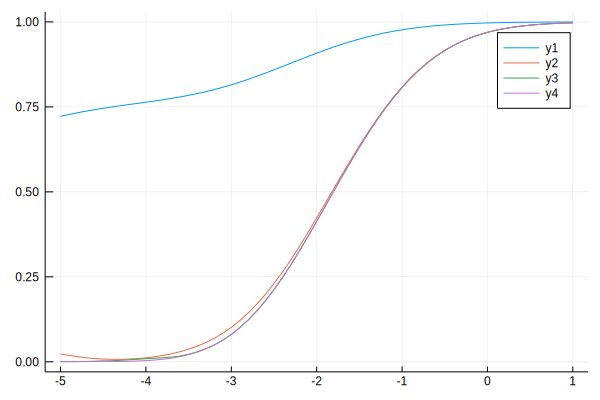

In [31]:
s = -5:.1:1
y1 = [det(I-lanczos(x,1)) for x in s]
y2 = [det(I-lanczos(x,2)) for x in s]
y3 = [det(I-lanczos(x,3)) for x in s]
y4 = [det(I-lanczos(x,4)) for x in s]
plot(s,[y1 y2 y3 y4])

In [50]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16867991284306361128\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13024426466687630603\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16867991284306361128\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [76]:
@manipulate for s = -5:.1:5
    q = eigvecs(lanczos(s,50,200))[1,:]
    plot(q.^2, label="$(s)")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["s"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 101,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/edelman/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/edelman/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/edelman/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/edelman/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/edelman/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000129eefcd0, Task (runnable) @0x0000000129eefcd0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-5.0\",\"-4.9\",\"-4.8\",\"-4.7\",\"-4.6\",\"-4.5\",\"-4.4\",\"-4.3\",\"-4.2\",\"-4.1\",\"-4.0\",\"-3.9\",\"-3.8\",\"-3.7\",\"-3.6\",\"-3.5\",\"-3.4\",\"-3.3\",\"-3.2\",\"-3.1\",\"-3.0\",\"-2.9\",\"-2.8\",\"-2.7\",\"-2.6\",\"-2.5\",\"-2.

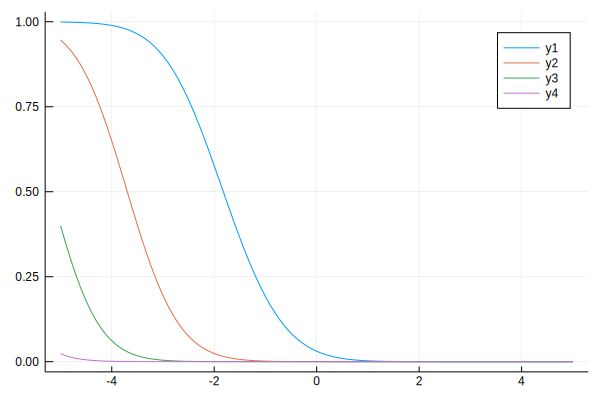

In [93]:
s = -5:.1:5
y = [eigvals(lanczos(x)) for x in s]
plot(s,[yy[10] for yy in y])
plot!(s,[yy[9] for yy in y])
plot!(s,[yy[8] for yy in y])
plot!(s,[yy[7] for yy in y])

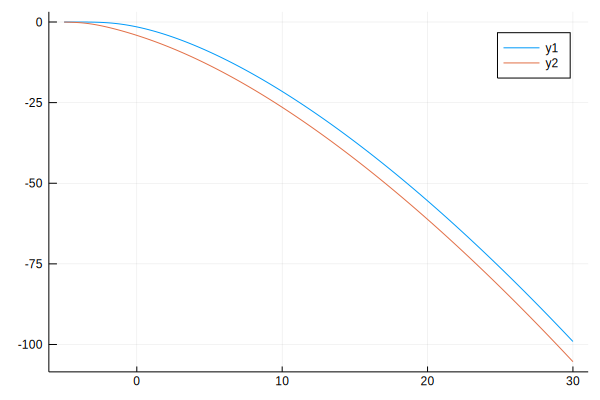

In [100]:
s = -5:.1:30
y1 = [log10.(eigvals(lanczos(x))[10]) for x in s]
y2 = [log10.(eigvals(lanczos(x))[9]) for x in s]
y3 = [log10.(eigvals(lanczos(x))[9]) for x in s]
plot(s,[y1 y2 ])